In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Sampler
from NST import NST
from itertools import cycle
import time

#Use silicon gpu/cuda gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Current device:", device)

Current device: mps


In [2]:
#implementation based on https://github.com/naoto0804/pytorch-AdaIN
class AdaIN(NST):
    def __init__(self, prebuild_encoder = None, prebuild_decoder = None, device = device):
        super().__init__(prebuild_encoder, prebuild_decoder, device)
        self.encoder = self._vgg()
        self.decoder = self._vggDecoder()
        self.mse_loss = nn.MSELoss()
        
    def setup(self, encoderSlice = 31, decoderSlice = None):
        if self.prebuild_encoder is not None:
            self.loadPrebuildEncoder(encoderSlice) 
        if self.prebuild_decoder is not None :
            self.loadPrebuildDecoder(decoderSlice) 
        self.encoder.to(self.device).eval()
        self.decoder.to(self.device)

        

    #Encoder by nato0804
    def _vgg(self):
        return nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(), 
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  
        )

    #Decoder by nato0804
    def _vggDecoder(self):
        return nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
        )

    #Adain implementation by nato0804
    #Calcualte mean and variance
    def _calc_mean_std(self, feat, eps=1e-5):
        N, C = feat.size()[:2]
        feat_ = feat.view(N, C, -1)
        mean = feat_.mean(dim=2).view(N, C, 1, 1)
        std = feat_.var(dim=2).add(eps).sqrt().view(N, C, 1, 1)
        return mean, std

    #Matching style with features 
    def _adain(self, content_feat, style_feat, alpha=1.0):
        c_mean, c_std = self._calc_mean_std(content_feat)
        s_mean, s_std = self._calc_mean_std(style_feat)
        normalized = (content_feat - c_mean) / c_std
        stylized = normalized * s_std + s_mean
        return alpha * stylized + (1 - alpha) * content_feat

    def _calc_content_loss(self, input, target):
        return self.mse_loss(input, target)

    def _calc_style_loss(self, input, target):
        input_mean, input_std = self._calc_mean_std(input)
        target_mean, target_std = self._calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)


    def train(self, train_content_loader, train_style_loader, path_name,learn_rate = 1e-4, steps=160000, lr_decay = 5e-5, content_weight = 1.0, style_weight=1.0, log_interval = 500):
        #freeze encoder
        self.encoder.to(self.device).eval()
        
        #Train decoder
        self.decoder.to(self.device).train()

        #enable content and style image to be cycled through
        contents = cycle(train_content_loader)
        styles = cycle(train_style_loader)

        total_content_loss = 0
        total_style_loss = 0
        total_total_loss = 0
        
        optimizer = torch.optim.Adam(self.decoder.parameters(), lr=learn_rate)
        for step in range(steps):
            #Loop the images to prevent images from running out
            content, content_label = next(contents)
            style, style_label = next(styles)

            #Transfer to available gpu
            content = content.to(self.device)
            style = style.to(self.device)
            
            lr = learn_rate / (1.0 + lr_decay * step)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

           
            #Encode image
            n_c, (n_s,) = self.encodeAll(content, [style])
            #Transformer
            features = self._adain(n_c,n_s)
            
            #Decode
            output = self.decoder(features)
    
            #Enocde the output again
            newOutput = self.encoder(output)
    
            #Calculate content and style loss
            content_loss = self._calc_content_loss(newOutput, features) * content_weight
            style_loss = self._calc_style_loss(newOutput, n_s) * style_weight
    
            #Total loss
            loss = content_loss+style_loss

            total_content_loss += content_loss
            total_style_loss += style_loss
            total_total_loss += loss
            
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if step % log_interval == 0 and step != 0:
                #Average losses
                print(f"[{step}/{steps}] content={total_content_loss/log_interval:.2f} style={total_style_loss/log_interval:.2f} total={total_total_loss/log_interval:.3f}")
                #Clear 
                total_content_loss = 0
                total_style_loss = 0
                total_total_loss = 0
                #Clear cache to prevent crash
                if self.device.type == "mps":
                    torch.mps.empty_cache()

        torch.save(self.decoder.state_dict(), path_name)
                
    
        
        
    def stylisation(self, contentFeature, styleFeatures, alpha = 1.0):
        adaINOut = self._adain(contentFeature, styleFeatures[0], alpha) #Handle 1 style currently
        return adaINOut

        
    def spatialControl(self, foreground_style_index = None, background_style_index = None):

        #Remove background and alpha
        self.content.removeBackground()
        self.content.extractAlpha()
        content = self.tensorisedContent
        styles = self.tensorisedStyles
        dimension = content.dim()

        #tensorise mask
        foreMask = torch.tensor(self.content.alphaOutput(), dtype=torch.float32, device = self.device)

        #Add dimension if insufficient
        while foreMask.dim() < content.dim():
            foreMask = foreMask.unsqueeze(0)
        
        #Mask for style and content
        foreStyle = (styles[foreground_style_index]) if foreground_style_index != None else None
        backStyle = (styles[background_style_index]) if background_style_index != None else None

        #Extract Features
        contentFeature = self.encoder(content)
        foreFeatureStyle = self.encoder(foreStyle) if foreground_style_index != None else None
        backFeatureStyle = self.encoder(backStyle) if background_style_index != None else None

        #Apply Adain
        styledForeground = self.stylisation(contentFeature, [foreFeatureStyle]) if foreFeatureStyle != None else contentFeature
        styledBackground = self.stylisation(contentFeature, [backFeatureStyle]) if backFeatureStyle != None else contentFeature

        #Resize mask
        d1,d2,h,w = contentFeature.shape
        foreMaskFeature = nn.functional.interpolate(foreMask, size=(h,w), mode="bilinear", align_corners=False)
        backMaskFeature = 1 - foreMaskFeature

        #Combine - prevent leak using masks
        combinedFeature = foreMaskFeature * styledForeground + backMaskFeature * styledBackground

        self.decoding(combinedFeature)

    #Call pipeline and test time
    def pipeline(self, alpha = 1.0):
        self.start = time.perf_counter()
        #Encode image
        n_c,n_s = self.encodeAll(self.tensorisedContent,self.tensorisedStyles)
        #Transformer
        features = self.stylisation(n_c,n_s, alpha)
        #Decode
        self.decoding(features)
        self.end = time.perf_counter()



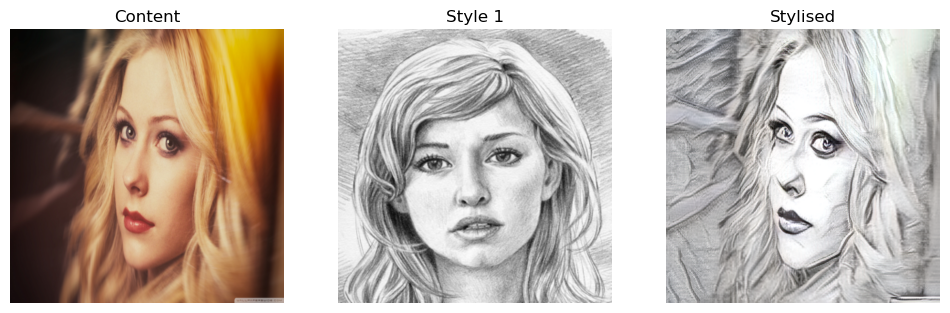

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.708, '203.330 ms')

In [3]:
style_path = "style/sketch.png"
prebuildEncoder = "vgg.pth"
prebuildDecoder = "decoder-adain.pth"
image_path = "content/avril.jpg"


adainModel = AdaIN(prebuildEncoder, prebuildDecoder)
adainModel.setup()
adainModel.fit(image_path, [style_path])
adainModel.pipeline()
adainModel.displayImages()
adainModel.evaluate()

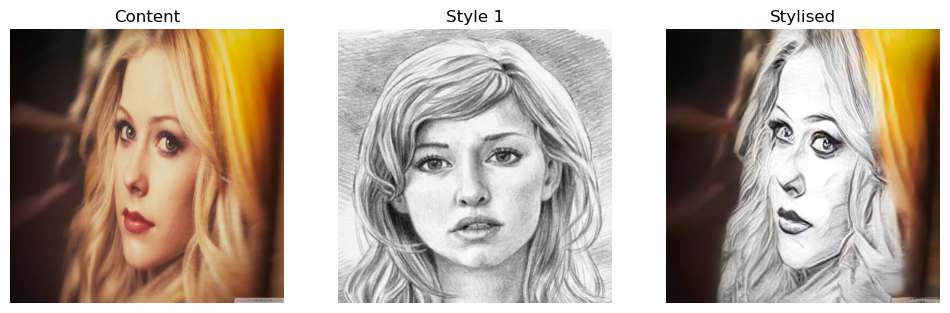

In [4]:
adainModel.spatialControl(0)
adainModel.displayImages()

In [5]:
print(resnet50(weights=ResNet50_Weights.DEFAULT))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

#coco content
train_content_dataset = datasets.ImageFolder(
    root= "../coco",             
    transform=transform
)

#wikiart
train_style_dataset = datasets.ImageFolder(
    root= "../archive",             
    transform=transform
)

train_content_loader = DataLoader(train_content_dataset, batch_size=1, shuffle=True)
train_style_loader = DataLoader(train_style_dataset, batch_size=1, shuffle=True)


In [7]:
# newAdaINModel = AdaIN()
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
encoder = nn.Sequential(*list(resnet.children())[:6])
# newAdaINModel.uploadEncoder(encoder)
# newAdaINModel.train(train_content_loader, train_style_loader, "resnet-model-layer2.pth", steps = 50000)

In [8]:

# newAdaINModel.fit(image_path,[style_path])
# newAdaINModel.pipeline(newAdaINModel.stylisation)
# newAdaINModel.displayImages()
# newAdaINModel.evaluate()

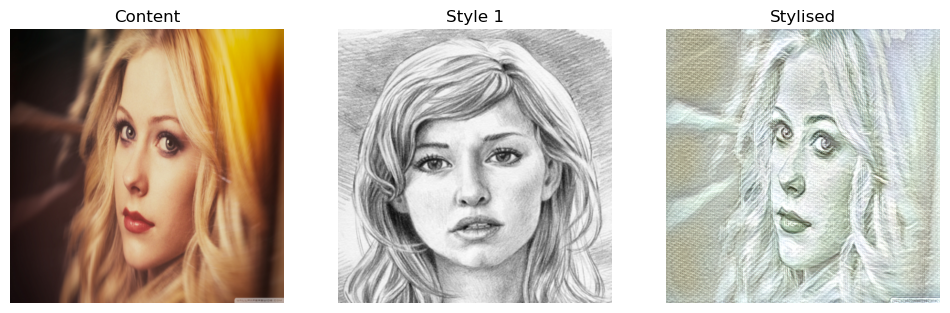

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.796, '131.883 ms')

In [9]:
#Verify result
layer2ResAdaIN = AdaIN(prebuild_decoder="resnet-model-layer2.pth")
layer2ResAdaIN.uploadEncoder(encoder)
layer2ResAdaIN.loadPrebuildDecoder()
layer2ResAdaIN.setup()
layer2ResAdaIN.fit(image_path,[style_path])
layer2ResAdaIN.pipeline(3.0)
layer2ResAdaIN.displayImages()
layer2ResAdaIN.evaluate()

In [ ]:
resL3Model = AdaIN()
resnetL3 = resnet50(weights=ResNet50_Weights.DEFAULT)
l3Encoder = nn.Sequential(*list(resnetL3.children())[:7])
resL3Model.uploadEncoder(l3Encoder)

layer3Decoder =nn.Sequential(
                nn.Conv2d(1024, 512, 1),
                nn.ReflectionPad2d(1),
                nn.Conv2d(512, 256, 3),
                nn.ReLU(inplace=True),
                
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ReflectionPad2d(1),
                nn.Conv2d(256, 256, 3),
                nn.ReLU(inplace=True),
                
                nn.ReflectionPad2d(1),
                nn.Conv2d(256, 256, 3),
                nn.ReLU(inplace=True),

                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ReflectionPad2d(1),
                nn.Conv2d(256, 256, 3),
                nn.ReLU(inplace=True),

                nn.ReflectionPad2d(1),
                nn.Conv2d(256, 256, 3),
                nn.ReLU(inplace=True),
                
                nn.ReflectionPad2d(1),
                nn.Conv2d(256, 128, 3),
                nn.ReLU(inplace=True),
                
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ReflectionPad2d(1),
                nn.Conv2d(128, 128, 3),
                nn.ReLU(inplace=True),
                
                nn.ReflectionPad2d(1),
                nn.Conv2d(128, 64, 3),
                nn.ReLU(inplace=True),
                
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.ReflectionPad2d(1),
                nn.Conv2d(64, 64, 3),
                nn.ReLU(inplace=True),
                
                nn.ReflectionPad2d(1),
                nn.Conv2d(64, 3, 3),
                nn.Sigmoid()
            )

resL3Model.uploadDecoder(layer3Decoder)
resL3Model.train(train_content_loader, train_style_loader, "resnet-model-layer3.pth", steps = 70000)

[500/70000] content=0.78 style=0.45 total=1.222
[1000/70000] content=0.76 style=0.44 total=1.202
[1500/70000] content=0.76 style=0.43 total=1.191
[2000/70000] content=0.75 style=0.43 total=1.186
[2500/70000] content=0.76 style=0.43 total=1.196
[3000/70000] content=0.76 style=0.44 total=1.194
[3500/70000] content=0.75 style=0.43 total=1.183
[4000/70000] content=0.76 style=0.43 total=1.191
[4500/70000] content=0.75 style=0.43 total=1.183
[5000/70000] content=0.76 style=0.43 total=1.190
[5500/70000] content=0.77 style=0.44 total=1.205
[6000/70000] content=0.76 style=0.43 total=1.190
[6500/70000] content=0.76 style=0.43 total=1.190
[7000/70000] content=0.76 style=0.43 total=1.192
[7500/70000] content=0.76 style=0.44 total=1.202
[8000/70000] content=0.76 style=0.43 total=1.195
[8500/70000] content=0.75 style=0.43 total=1.186
[9000/70000] content=0.76 style=0.44 total=1.201
[9500/70000] content=0.75 style=0.43 total=1.179
[10000/70000] content=0.75 style=0.43 total=1.185


In [ ]:
resL3Model.fit(image_path,[style_path])
resL3Model.pipeline(resL3Model.stylisation)
resL3Model.displayImages()
resL3Model.evaluate()